In [314]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from numpy import inf
from numpy import nan
from os.path import join
import os
import fnmatch
from datetime import datetime, date, time
from skimage import measure
import configparser, logging
#from libtiff import TIFF
from libtiff import TIFFfile, TIFFimage
#mdir='/home/alex/Yandex.Disk/data/keo/2016/10/27'


In [315]:
def fill_cell(cell, corner, rad):
    m, n = cell.shape
    ctr = corner[0]+m/2, corner[1]+n/2
    x = np.arange(m) - ctr[0]
    y = np.arange(n) - ctr[1]
    X,Y = np.meshgrid(x, y,indexing='ij')  # could try order='xy'
    Z = ((X**2 + Y**2)<= rad**2).astype(cell.dtype)
    return Z

def do_mask(NAXIS1,NAXIS2,isKEO):
    if (isKEO):
        mask=np.zeros((NAXIS1,NAXIS2))
        mask[:] = fill_cell(mask, (0,0),(NAXIS1//2-5))
        mask[mask==0]=nan
    else:
        mask=np.ones((NAXIS1,NAXIS2))
        mask[:,:30]=nan
        mask[:,-50:]=nan
        mask[1,:]=nan
        mask[-1,:]=nan
   
    return mask

def fill_tst_arr(tst_arr,fill):
    tst_koor=np.zeros((4,4), dtype="uint16")
    if fill>0:
        #tst_arr=np.zeros((511,511))
        tst_arr=np.random.uniform(300,600, size=(511, 511))
    tst_koor[0,:]=[400,410,350,355]
    tst_koor[1,:]=[205,208,205,208]
    tst_koor[2,:]=[300,305,305,310]
    tst_koor[3,:]=[305,309,310,315]
    
    for tsti in range(0,tst_koor.shape[1]):
        if fill>0:
            tst_arr[tst_koor[tsti,0]:tst_koor[tsti,1],tst_koor[tsti,2]:tst_koor[tsti,3]]=800
            #tst_arr=np.random.random((10,10))
            tst_arr[tst_koor[tsti,0]+1:tst_koor[tsti,1]-1,tst_koor[tsti,2]+1:tst_koor[tsti,3]-1]=850
            #tst_arr
            print('fill')
        #print(tst_koor[tsti,:])
        #print(tst_arr[tst_koor[tsti,0]:tst_koor[tsti,1],tst_koor[tsti,2]:tst_koor[tsti,3]])
        tst_arr[-1,:] = nan
        tst_arr[:,-1] = nan
        tst_arr[0,:] = nan
        tst_arr[:,0] = nan
        print(tst_koor[tsti,:])
        print(tst_arr[tst_koor[tsti,0]:tst_koor[tsti,1],tst_koor[tsti,2]:tst_koor[tsti,3]])
    return tst_arr

def save_tiff(data_full_tiff,fname,proc):
    #data_full_tiff=data_full.copy()
    if proc>0:
        dmin=data_full_tiff[~np.isnan(data_full_tiff)].min()
        dmax=data_full_tiff[~np.isnan(data_full_tiff)].max()
        #print('min, max ', data_full_tiff[~np.isnan(data_full_tiff)].min(),data_full_tiff[~np.isnan(data_full_tiff)].max())
        data_full_tiff=(data_full_tiff-dmin+1)*(np.iinfo('uint16').max/(dmax-dmin+1))
        #print('min, max ', data_full_tiff[~np.isnan(data_full_tiff)].min(),data_full_tiff[~np.isnan(data_full_tiff)].max())
    
    tiff = TIFFimage(data_full_tiff.astype('uint16'), description='')
    #tiff.write_file(mdest+'/data_full.tiff', compression='none')
    tiff.write_file(fname, compression='none')
    del tiff
    return

def make_dir(mdest):
    if not(os.path.exists(mdest)):
        print('Make dir ', mdest)
        os.mkdir(mdest)
    return


In [316]:
def link_area(sig,noise,nMin,nMax):    
    mright=mdown=mupleft=0
    noise_mask=np.zeros(noise.shape, dtype="uint8")
    tnoise=np.zeros(noise.shape, dtype="uint8")
    tnoise[noise>0]=1
    #if noise[~np.isnan(tnoise)].size>0:
    #    print('tnoise - link-area. size ',noise[~np.isnan(tnoise)].size)
    #    plt.imshow(tnoise, cmap='gray')
    #    plt.show()
    #    plt.close()
    mreg=[]
    labels = measure.label(tnoise, neighbors=8, background=0,)
    regions=measure.regionprops(labels)
    
    for region in regions:
        if region == 0:
            continue
        #if (nMin<region.area<nMax):
        #print(' nMin , Region.area, nMax ',nMin , region.area, nMax)
        mbbox = region.bbox
        if region.area>nMin and region.area<nMax:
            #print('region area',region.area)
            #mbbox = region.bbox
            #print('mbbox ', mbbox)
            if (mbbox[2]<noise.shape[0])and(mbbox[3]<noise.shape[1]):
                rc=region.coords
                #for i in range(rc.shape[0]):
                #       noise_mask[rc[i,0],rc[i,1]]=1
                mreg.append(region)
                tmp_sig=sig[mbbox[0]-1:mbbox[2]+1,mbbox[1]-1:mbbox[3]+1].copy()
                #print('tmpsig ', tmp_sig)
                tmp_sig[1:-1,1:-1] = nan
                mean_val=np.mean(tmp_sig[~np.isnan(tmp_sig)])
                for i in range(rc.shape[0]):
                    sig[rc[i,0],rc[i,1]]=mean_val
                    noise_mask[rc[i,0],rc[i,1]]=1
                    #sig[rc[i,1],rc[i,0]]=mean_val
                #print('complete sig ', sig[mbbox[0]-1:mbbox[2]+1,mbbox[1]-1:mbbox[3]+1])
                #print('noise mask  ', noise_mask[mbbox[0]-1:mbbox[2]+1,mbbox[1]-1:mbbox[3]+1])
            else:
                if mbbox[3]>=noise.shape[1]:
                    st_right=noise.shape[1]-mbbox[1]+1
                    if mright<st_right:
                        mright=st_right
                #elif mbbox[2]>=noise.shape[0]:
                if mbbox[2]>=noise.shape[0]:
                    st_down=noise.shape[0]-mbbox[0]+1
                    if mdown<st_down:
                        mdown=st_down
                #else:
                 #   mupleft=1
        else:
            if mbbox[3]>=noise.shape[1]:
                st_right=noise.shape[1]-mbbox[1]+1
                if mright<st_right:
                    mright=st_right
            if mbbox[2]>=noise.shape[0]:
                    st_down=noise.shape[0]-mbbox[0]+1
                    if mdown<st_down:
                        mdown=st_down
                    
    noise=noise*noise_mask
    noise[noise==0]=nan
    #print('noise  ', noise[noise_mask>0])
    return sig,noise,mreg,mright,mdown,mupleft
    
def ident_noise(sig,koef_porog,nMin,nMax):
    if sig.shape[0]!=sig.shape[1]:
        print('Error win size (ident_noise)')
        print('sig.shape, noise.shape', sig.shape)
    m_size=sig.shape[0]
    nMin=nMin-1
    noise=np.zeros((m_size,m_size))
    noise[noise==0]=nan
    koef_noise=sig[~np.isnan(sig)].std()
    porog_win=np.mean(sig[~np.isnan(sig)])+koef_porog*koef_noise;#Расчет порога
    #mean_sig=np.mean(sig[~np.isnan(sig)])
    #porog_win=mean_sig*koef_porog
    #print('sig.shape, noise.shape' sig.shape)
    noise[sig>porog_win]=sig[sig>porog_win]
    #if noise[~np.isnan(noise)].size>0:
        #print('noise - ident-noise. size ',noise[~np.isnan(noise)].size)
        #plt.imshow(noise, cmap='gray')
        #plt.show()
        #plt.close()
    sig,noise,regions,mright,mdown,mupleft=link_area(sig,noise,nMin,nMax)
    #if noise[~np.isnan(noise)].size>0:
    #    print('noise - ident-noise. size ',noise[~np.isnan(noise)].size)
    #    plt.imshow(noise, cmap='gray')
    #    plt.show()
    #    plt.close()
    if mupleft==1:
        print('Warning UP - LEFT')
    sig_filtr=sig
    return sig_filtr,noise,regions, mright,mdown

def proc_kadr(data_full,n_win,nMin,nMax,porog,nproc):
    
    #n_win=proc_list[0]["nwin"]
    #nMin=proc_list[0]["nmin"]
    #nMax=proc_list[0]["nmax"]
    #porog=proc_list[0]["porog"]
    
    data_full_filtr=data_full.copy()
    #data_full_filtr=np.zeros((NAXIS1,NAXIS2))
    noise_full=np.zeros((NAXIS1,NAXIS2))
    
    beg_x=beg_y=end_x=end_y=0

    size_win_beg=((NAXIS1+n_win)//n_win)+1#260
    #print(size_win_beg)

    win_arr=np.zeros((n_win,n_win,4), dtype="int16")
    #print(win_arr)
    for i in range(n_win):#0 - xbeg, 1 - xend, 2- ybeg, 3 - yend
        if i>0:
            win_arr[i,:,0] =win_arr[i-1,0,1]-1
        else:
            win_arr[i,:,0]=0
        win_arr[i,:,1] = win_arr[i,:,0]+size_win_beg
        for j in range(n_win):
            if j>0:
                win_arr[i,j,2] =win_arr[i,j-1,3]-1
            else:
                win_arr[i,j,2] =0
            win_arr[i,j,3] = win_arr[i,j,2]+size_win_beg
    win_arr[-1,:,0][win_arr[-1,:,1]>NAXIS2]=NAXIS2-size_win_beg
    win_arr[-1,:,1][win_arr[-1,:,1]>NAXIS2]=NAXIS2
    win_arr[:,-1,2][win_arr[:,-1,3]>NAXIS1]=NAXIS1-size_win_beg
    win_arr[:,-1,3][win_arr[:,-1,3]>NAXIS1]=NAXIS1
    
   
    #for i in range(n_win):
        #for j in range(n_win):
            #print('begin nproc', nproc, win_arr[i,j,1]-win_arr[i,j,0], win_arr[i,j,3]-win_arr[i,j,2])


    #plt.imshow(data_full, cmap='gray')
    #plt.show()
    #plt.close()
    #regions_info=
    all_regions=[]
    for i in range(n_win): #down
        for j in range(n_win): #right
            #Проверить!!! Надо обойтись            
            win_arr[-1,:,0][win_arr[-1,:,1]>NAXIS2]=NAXIS2-size_win_beg
            win_arr[-1,:,1][win_arr[-1,:,1]>NAXIS2]=NAXIS2
            win_arr[:,-1,2][win_arr[:,-1,3]>NAXIS1]=NAXIS1-size_win_beg
            win_arr[:,-1,3][win_arr[:,-1,3]>NAXIS1]=NAXIS1
            xbeg=win_arr[i,j,0]
            xend=win_arr[i,j,1]
            ybeg=win_arr[i,j,2]
            yend=win_arr[i,j,3]
            #print('xbeg, xend, ybeg, yend i, j',xbeg,xend,ybeg,yend,i,j)
            if (win_arr[i,j,1]-win_arr[i,j,0])!= (win_arr[i,j,3]-win_arr[i,j,2]):
                    print('Error 1, size_win', nproc, win_arr[i,j,:],size_win,i,j)
            
            data_filtr,noise,regions,mright,mdown=ident_noise(data_full[xbeg:xend,ybeg:yend].copy(),porog,nMin,nMax)
            #regions_list=list(regions)
            for region in regions:
                temp_list=[region.area,region.bbox,region.bbox_area,region.centroid,region.convex_area,region.convex_image
                           ,region.coords,region.eccentricity,region.equivalent_diameter,region.euler_number
                           ,region.extent,region.filled_area,region.filled_image,region.image,region.label,region.major_axis_length
                           ,region.minor_axis_length,region.moments,region.moments_central,region.moments_hu
                           ,region.moments_normalized,region.orientation,region.perimeter,region.solidity]
                #for reg in
                #for tmp in temp_list:
                #    tmp=list(tmp)
                temp_list[3]=list(temp_list[3])
                temp_list[3][0]=temp_list[3][0]+xbeg #Проверить x y. Если не сходится, поменять xbeg на ybeg
                temp_list[3][1]=temp_list[3][1]+ybeg
                all_regions.append(temp_list)
                
            #if (i==0)and(j==0):
            #    all_regions=regions_list.copy()
            #else:
            #    all_regions=all_regions+regions_list.copy()
                
            #if (i==0)and(j==0):
                #all_regions=regions.copy()
                
            #else:
            #    all_regions=all_regions+regions.copy()
           
            for (tx,ty),vl in np.ndenumerate(data_filtr):
                if ~np.isnan(vl):
                    data_full_filtr[xbeg+tx,ybeg+ty]=vl
            for (tx,ty),vl in np.ndenumerate(noise):
                if ~np.isnan(vl):
                    noise_full[xbeg+tx,ybeg+ty]=vl
            #data_full_filtr[xbeg:xend,ybeg:yend]=data_filtr.copy()
            #noise_full[xbeg:xend,ybeg:yend]=noise.copy()
            
            if mdown>0:
                #print('mdown')
                size_win=win_arr[i+1,j,1]-win_arr[i+1,j,0]+mdown            
                win_arr[i+1,j,2]=win_arr[i+1,j,2]-mdown
                if win_arr[i+1,j,2]<0:
                    win_arr[i+1,j,2]=0
                win_arr[i+1,j,3]=win_arr[i+1,j,2]+size_win
                win_arr[i+1,j,0]=win_arr[i+1,j,0]-mdown
                if win_arr[i+1,j,0]<0:
                    win_arr[i+1,j,0]=0
                win_arr[i+1,j,1]=win_arr[i+1,j,0]+size_win
                if (win_arr[i+1,j,1]-win_arr[i+1,j,0])!= (win_arr[i+1,j,3]-win_arr[i+1,j,2]):
                    print('Error 3, size_win', nproc, win_arr[i,j,:],size_win)
            if mright>0:
                #print('mright')
                if win_arr[i,j+1,3]-win_arr[i,j+1,2]<size_win_beg+mright:
                    #print('do mright')
                    size_win=win_arr[i,j+1,3]-win_arr[i,j+1,2]+mright
                    win_arr[i,j+1,0]=win_arr[i,j+1,0]-mright
                    if win_arr[i,j+1,0]<0:
                        win_arr[i,j+1,0]=0
                    win_arr[i,j+1,1]=win_arr[i,j+1,0]+size_win
                    win_arr[i,j+1,2]=win_arr[i,j+1,2]-mright
                    if win_arr[i,j+1,2]<0:
                        win_arr[i,j+1,2]=0
                    win_arr[i,j+1,3]=win_arr[i,j+1,2]+size_win
                    #if (win_arr[i,j+1,1]-win_arr[i,j+1,0])!= (win_arr[i,j+1,3]-win_arr[i,j+1,2]):
                    #    print('Error 2 nproc, size_win', nproc, win_arr[i,j+1,:],size_win)
                    
            #if (win_arr[i,j,1]-win_arr[i,j,0])!= (win_arr[i,j,3]-win_arr[i,j,2]):
            #    print('Error 3 nproc, size_win', nproc, win_arr[i,j,:],size_win)
                            
    if data_full[data_full==0].size>0:
        print('>zero. nproc = ',nproc)
    #plt.imshow(data_filtr, cmap='gray')
    #plt.show()
    
    #plt.close()
    #plt.imshow(noise_full, cmap='gray')
    #plt.show()
    #plt.close()
    #plt.imshow(data_full_filtr, cmap='gray')
    #plt.show()
    #plt.close()
    #for i in range(n_win):
        #for j in range(n_win):
            #print('begin nproc', nproc, win_arr[i,j,1]-win_arr[i,j,0], win_arr[i,j,3]-win_arr[i,j,2])
    return data_full_filtr,noise_full,all_regions

In [317]:


#np.set_printoptions(threshold='nan')

config = configparser.ConfigParser()
config.read('KEO_filter.cfg')

mdir=config.get("Paths", "source")
mdest=config.get("Paths", "destination")

flog=config.get("Log", "Name")
save_fits_bool=int(config.get("save", "fits"))
save_tiff_bool=int(config.get("save", "tiff"))
num_proc=int(config.get("proc settings", "num_proc"))
#print(num_proc)
proc_list={}
for i in range(num_proc):
    name_proc="proc "+str(i)
    proc_list[i]={
            "name":config.get(name_proc, "name"),
            "nwin":int(config.get(name_proc, "nwin")),
            "nmin":int(config.get(name_proc, "nmin")),
            "nmax":int(config.get(name_proc, "nmax")),
            "porog":float(config.get(name_proc, "porog"))
        }
   

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
handler = logging.FileHandler(flog)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

logger.info('Start')

path_f = []
file_ext = '*.fit.gz'#расширение файлов для поиска
#path = '/temp/download' #путь поиска вложенных файлов
for root, dirs, files in os.walk(mdir):
    for name in files:
        if fnmatch.fnmatch(name, file_ext):
            path = os.path.join(root,name) # формирование адреса
            path_f.append(path) # добавление адреса в список
            
path_f.sort()
mlen=len(path_f)
logger.info('%d files found',mlen)
#mcount=100

hdulist = fits.open(path_f[0])
#hdulist.info()
#print(hdulist[0].header)
isKEO=(int(hdulist[0].header['NAXIS'])==2)
if (isKEO):
    #print(isKEO)
    exptime=hdulist[0].header['EXPTIME']
    date_obs=hdulist[0].header['DATE-OBS']
    mdest+='/'+date_obs[:date_obs.find('T')].replace('-','') 
else:
    exptime=hdulist[0].header['EXPOSURE']
    date_obs=hdulist[0].header['DATE']
    mdest+='/'+date_obs[:date_obs.find('T')].replace('-','')
    
print(mdest)
make_dir(mdest)
make_dir(mdest+'/source')
NAXIS1=hdulist[0].header['NAXIS1']
NAXIS2=hdulist[0].header['NAXIS2']

mask=do_mask(NAXIS1,NAXIS2,isKEO)
#exptime=hdulist[0].header['EXPTIME']
#date_obs=hdulist[0].header['DATE-OBS']
#dt=datetime.strptime(date_obs,"%Y-%m-%dT%H:%M:%S")
#print(dt)
#for file_proc in range(mlen):
for file_proc in range(2):
    hdulist = fits.open(path_f[file_proc])
    if (isKEO):
        data_full = hdulist[0].data*mask
    else:
        data_full = hdulist[0].data[0]*mask
    new_hdul = fits.HDUList()
    #hdulist.info()
    #print(hdulist[0].header)
    #NAXIS1=hdulist[0].header['NAXIS1']
    #NAXIS2=hdulist[0].header['NAXIS2']
    
    
    dt=datetime.strptime(date_obs,"%Y-%m-%dT%H:%M:%S")
    fname=path_f[file_proc].split('/')[-1][:path_f[file_proc].split('/')[-1].find('.')]
    #data_full=fill_tst_arr(data_full,1)
    if (save_tiff_bool)==1:
        save_tiff(data_full.copy(),mdest+'/source/' + fname+'-source.tiff',1)
    #save_tiff(data_full.copy(),'source.tiff',1)
    for nproc in proc_list:
        make_dir(mdest+'/n'+str(nproc))
        make_dir(mdest+'/f'+str(nproc))
        n_win=proc_list[nproc]["nwin"]
        nMin=proc_list[nproc]["nmin"]
        nMax=proc_list[nproc]["nmax"]
        porog=proc_list[nproc]["porog"]
        if nproc==0:
            data_full_filtr=data_full#np.zeros((NAXIS1,NAXIS2))
        
        data_full_filtr,noise_full,all_regions=proc_kadr(data_full_filtr,n_win,nMin,nMax,porog,nproc)
        
        print("all_regions",len(all_regions))
        sreg=np.zeros((len(all_regions),11))
        for sr in range(len(all_regions)):
            sreg[sr,0]=sr
            sreg[sr,1]=all_regions[sr][3][0]#centroid[0]
            sreg[sr,2]=all_regions[sr][3][1]#centroid[1]
            sreg[sr,3]=all_regions[sr][0] #area
            sreg[sr,4]=all_regions[sr][2] #bbox_area
            sreg[sr,5]=all_regions[sr][4] #convex_area
            sreg[sr,6]=all_regions[sr][7] #eccentricity
            sreg[sr,7]=all_regions[sr][8] #equivalent_diameter
            sreg[sr,8]=all_regions[sr][21] #orientation
            sreg[sr,9]=all_regions[sr][22] #perimeter
            sreg[sr,10]=all_regions[sr][23] #solidity
        np.savetxt(mdest+'/n' + str(nproc)+'/'+ fname+'-noise'+str(nproc)+'.info',sreg,
                   fmt='%d; %4.3f; %4.3f; %d; %d;  %d; %4.3f; %4.3f; %4.3f; %4.3f; %4.3f',
                  delimiter=';', 
                header='n; x; y; area; bbox_area; convex_area; eccentricity; equivalent_diameter; orientation; perimeter; solidity ')
        #import csv 
        #with open(mdest+"/список.csv", "w", newline='') as file:
        #    csv.writer(file).writerow(all_regions)
            
        if (save_fits_bool)==1:
            new_hdul.append(fits.ImageHDU())
            #new_hdul[nproc].header['NAXIS1']=NAXIS1
            #new_hdul[nproc].header['NAXIS2']=NAXIS2
            
            new_hdul[nproc].data=noise_full
        if (save_tiff_bool)==1:
            save_tiff(noise_full.copy(),mdest+'/n' + str(nproc)+'/'+ fname+'-noise'+str(nproc)+'.tiff',1)
            save_tiff(data_full_filtr.copy(),mdest+'/f' + str(nproc)+'/'+ fname+'-filtr'+str(nproc)+'.tiff',1)
    if (save_fits_bool)==1:        
        new_hdul.append(fits.ImageHDU())
        new_hdul[nproc+1].data=data_full
        new_hdul.append(fits.ImageHDU())
        new_hdul[nproc].header['SIMPLE']='T'
        new_hdul[nproc].header['BITPIX']=-64
        new_hdul[nproc].header['NAXIS']=2
        new_hdul[nproc].header['NAXIS1']=NAXIS1
        new_hdul[nproc].header['NAXIS2']=NAXIS2
        new_hdul[nproc+2].data=data_full_filtr
        if os.path.exists(mdest+'/'+fname+'.fits'):
            os.remove(mdest+'/'+fname+'.fits')
        #new_hdul.header=hdulist[0].header
        new_hdul.writeto(mdest+'/'+fname+'.fits')
        new_hdul.close

/home/alex/data/meteor_flares/testres/20180412


/home/alex/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/alex/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/alex/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/alex/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alex/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in greater
/home/alex/anaconda3/lib/python3.6/site-p

all_regions 6
all_regions 1


In [318]:

#sreg=np.zeros((len(all_regions),10))
#lst_reg=list(all_regions)
#all_regions=[list(region) for region in all_regions]
#print(all_regions[0].centroid[0])
#all_reg=[[list(reg) for reg in region] for region in all_regions]
#all_reg=list(map(list,all_regions))
#trp2list(all_regions)
#all_regions[0].centroid[0]=10
#all_regions[0].centroid=list(all_regions[0].centroid)
#setattr(all_regions[0],"centroid",1)
#all_regions[0]["centroid"]=(1,2)                        
print(len(all_regions[0]))


24


In [319]:
%whos

Variable          Type             Data/Info
--------------------------------------------
NAXIS1            int              511
NAXIS2            int              511
TIFFfile          type             <class 'libtiff.tiff_file.TIFFfile'>
TIFFimage         type             <class 'libtiff.tiff_image.TIFFimage'>
a                 ndarray          10x10: 100 elems, type `float64`, 800 bytes
all_reg           list             n=1
all_regions       list             n=1
b                 list             n=24
config            ConfigParser     <configparser.ConfigParse<...>object at 0x7f81d5ab5e80>
configparser      module           <module 'configparser' fr<...>thon3.6/configparser.py'>
csv               module           <module 'csv' from '/home<...>a3/lib/python3.6/csv.py'>
data_full         ndarray          511x511: 261121 elems, type `float64`, 2088968 bytes (1.9921951293945312 Mb)
data_full_filtr   ndarray          511x511: 261121 elems, type `float64`, 2088968 bytes (1.9921951293945

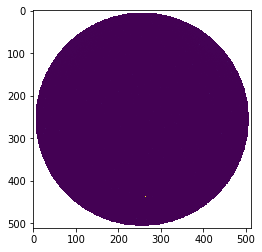

In [320]:
#print(data_full[np.isnan(data_full)])
#print(len(regions))
#noise_full[np.isnan(noise_full)]=0
plt.imshow(data_full)
plt.show()
#print(win_arr)
#%whos

In [321]:
print(hdulist[0].header)

SIMPLE  =                    T                                                  BITPIX  =                   16                                                  NAXIS   =                    2                                                  NAXIS1  =                  511                                                  NAXIS2  =                  511                                                  BZERO   =           32768.000000                                                BSCALE  =             1.000000                                                  DATAMIN =             0.000000                                                  DATAMAX =           65535.000000                                                INSTRUME=           'ART-4021: fw rev 4.04'                                     EXPTIME =           60.000                                                      DATE-OBS=           '2018-04-12T12:35:33'                                       XPIXSZ  =           29.600              

In [322]:
a=np.ones((10,10))
#a=((1,2,3,4),(5,6,7,8))
print(a)
a[:2,:]=nan
a[-2:,:]=nan
a[:,:1]=nan
a[:,-1:]=nan
print(a)

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]
[[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan   1.   1.   1.   1.   1.   1.   1.   1.  nan]
 [ nan   1.   1.   1.   1.   1.   1.   1.   1.  nan]
 [ nan   1.   1.   1.   1.   1.   1.   1.   1.  nan]
 [ nan   1.   1.   1.   1.   1.   1.   1.   1.  nan]
 [ nan   1.   1.   1.   1.   1.   1.   1.   1.  nan]
 [ nan   1.   1.   1.   1.   1.   1.   1.   1.  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
